<a href="https://colab.research.google.com/github/MichaelTj02/ComputerVision_Group17/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

In [4]:
#Michael's dataset location
test_dir = '/content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/val'
train_dir = '/content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/train'

In [ ]:
#Ryan's dataset location
test_dir = '/content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/val'
train_dir = '/content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/train'

We need to map labels to class_ids required for YOLO

In [5]:
#train
df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

#val
df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

In [6]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax


In [7]:
label_map = { 'with helmet': 0,
            'without helmet': 1,
            'rider': 2,
            'number plate': 3}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [8]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class


convertig the bounding box format to the one required by YOLO:




In [9]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [10]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height


converting the dataframe to type *str* (string) to be stored in text files.

In [11]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

# Custom object detection using YOLO

First install and import

In [13]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/112.6 GB disk)


In [14]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [15]:
model = YOLO('yolov8s.pt') # pretrained model

100%|██████████| 21.5M/21.5M [00:00<00:00, 231MB/s]


The detailed architecture of the model can be seen from:


In [16]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

**Michael's Path**

In [17]:
%%writefile config.yaml
path: /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset
train: /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train
#test: (test dataset folder path)
val: /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/val

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: with helmet
  1: without helmet
  2: rider
  3: number plate

Writing config.yaml


**Ryan's Path**

In [ ]:
%%writefile config.yaml

path: /content/drive/MyDrive/ComputerVisionProject
train: /content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/train
#test: (test dataset folder path)
val: /content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/val

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: with helmet
  1: without helmet
  2: rider
  3: number plate

Writing config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [24]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640, name="custom_training_run")

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=custom_training_run, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

train: Scanning /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/labels/train.cache... 143 images, 0 backgrounds, 2 corrupt: 100%|██████████| 145/145 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train/new128.jpg'
train: WARNING ⚠️ /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tiff', 'heic', 'bmp', 'jpg', 'webp', 'tif', 'dng', 'png', 'mpo', 'pfm', 'jpeg'}
videos: {'wmv', 'mpeg', 'ts', 'mp4', 'webm', 'm4v', 'asf', 'mpg', 'mov', 'avi', 'gif', 'mkv'}
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs/detect/custom_training_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/custom_training_run
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.41G      2.624      3.662      2.324         54        640: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

                   all         40        182      0.865      0.113      0.125     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.45G       1.85      2.938      1.773         60        640: 100%|██████████| 18/18 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         40        182       0.77      0.206      0.211       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       2.5G      1.558      2.326      1.537         50        640: 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         40        182      0.876      0.218      0.416      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.49G       1.39      1.951      1.408         56        640: 100%|██████████| 18/18 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

                   all         40        182      0.695      0.345      0.547      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.51G      1.413      1.732      1.416         68        640: 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         40        182      0.666      0.475      0.583      0.386



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/custom_training_run/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/custom_training_run/weights/best.pt, 22.5MB

Validating runs/detect/custom_training_run/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


                   all         40        182      0.666      0.475      0.583      0.386
           with helmet         23         31      0.554      0.323      0.472      0.298
        without helmet         20         39      0.498      0.462      0.511      0.352
                 rider         40         60      0.813       0.75      0.815      0.548
          number plate         38         52      0.799      0.365      0.534      0.348
Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/detect/custom_training_run


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787f6c6e5060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [25]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


                   all         40        182      0.666      0.475      0.584      0.387
           with helmet         23         31      0.553      0.323      0.477      0.301
        without helmet         20         39      0.497      0.462       0.51       0.35
                 rider         40         60      0.814       0.75      0.816      0.545
          number plate         38         52      0.798      0.365      0.534      0.352
Speed: 1.2ms preprocess, 13.6ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/custom_training_run2


0.47487593052109184

Showing confusion matrix, that is already stored in detect/train folder

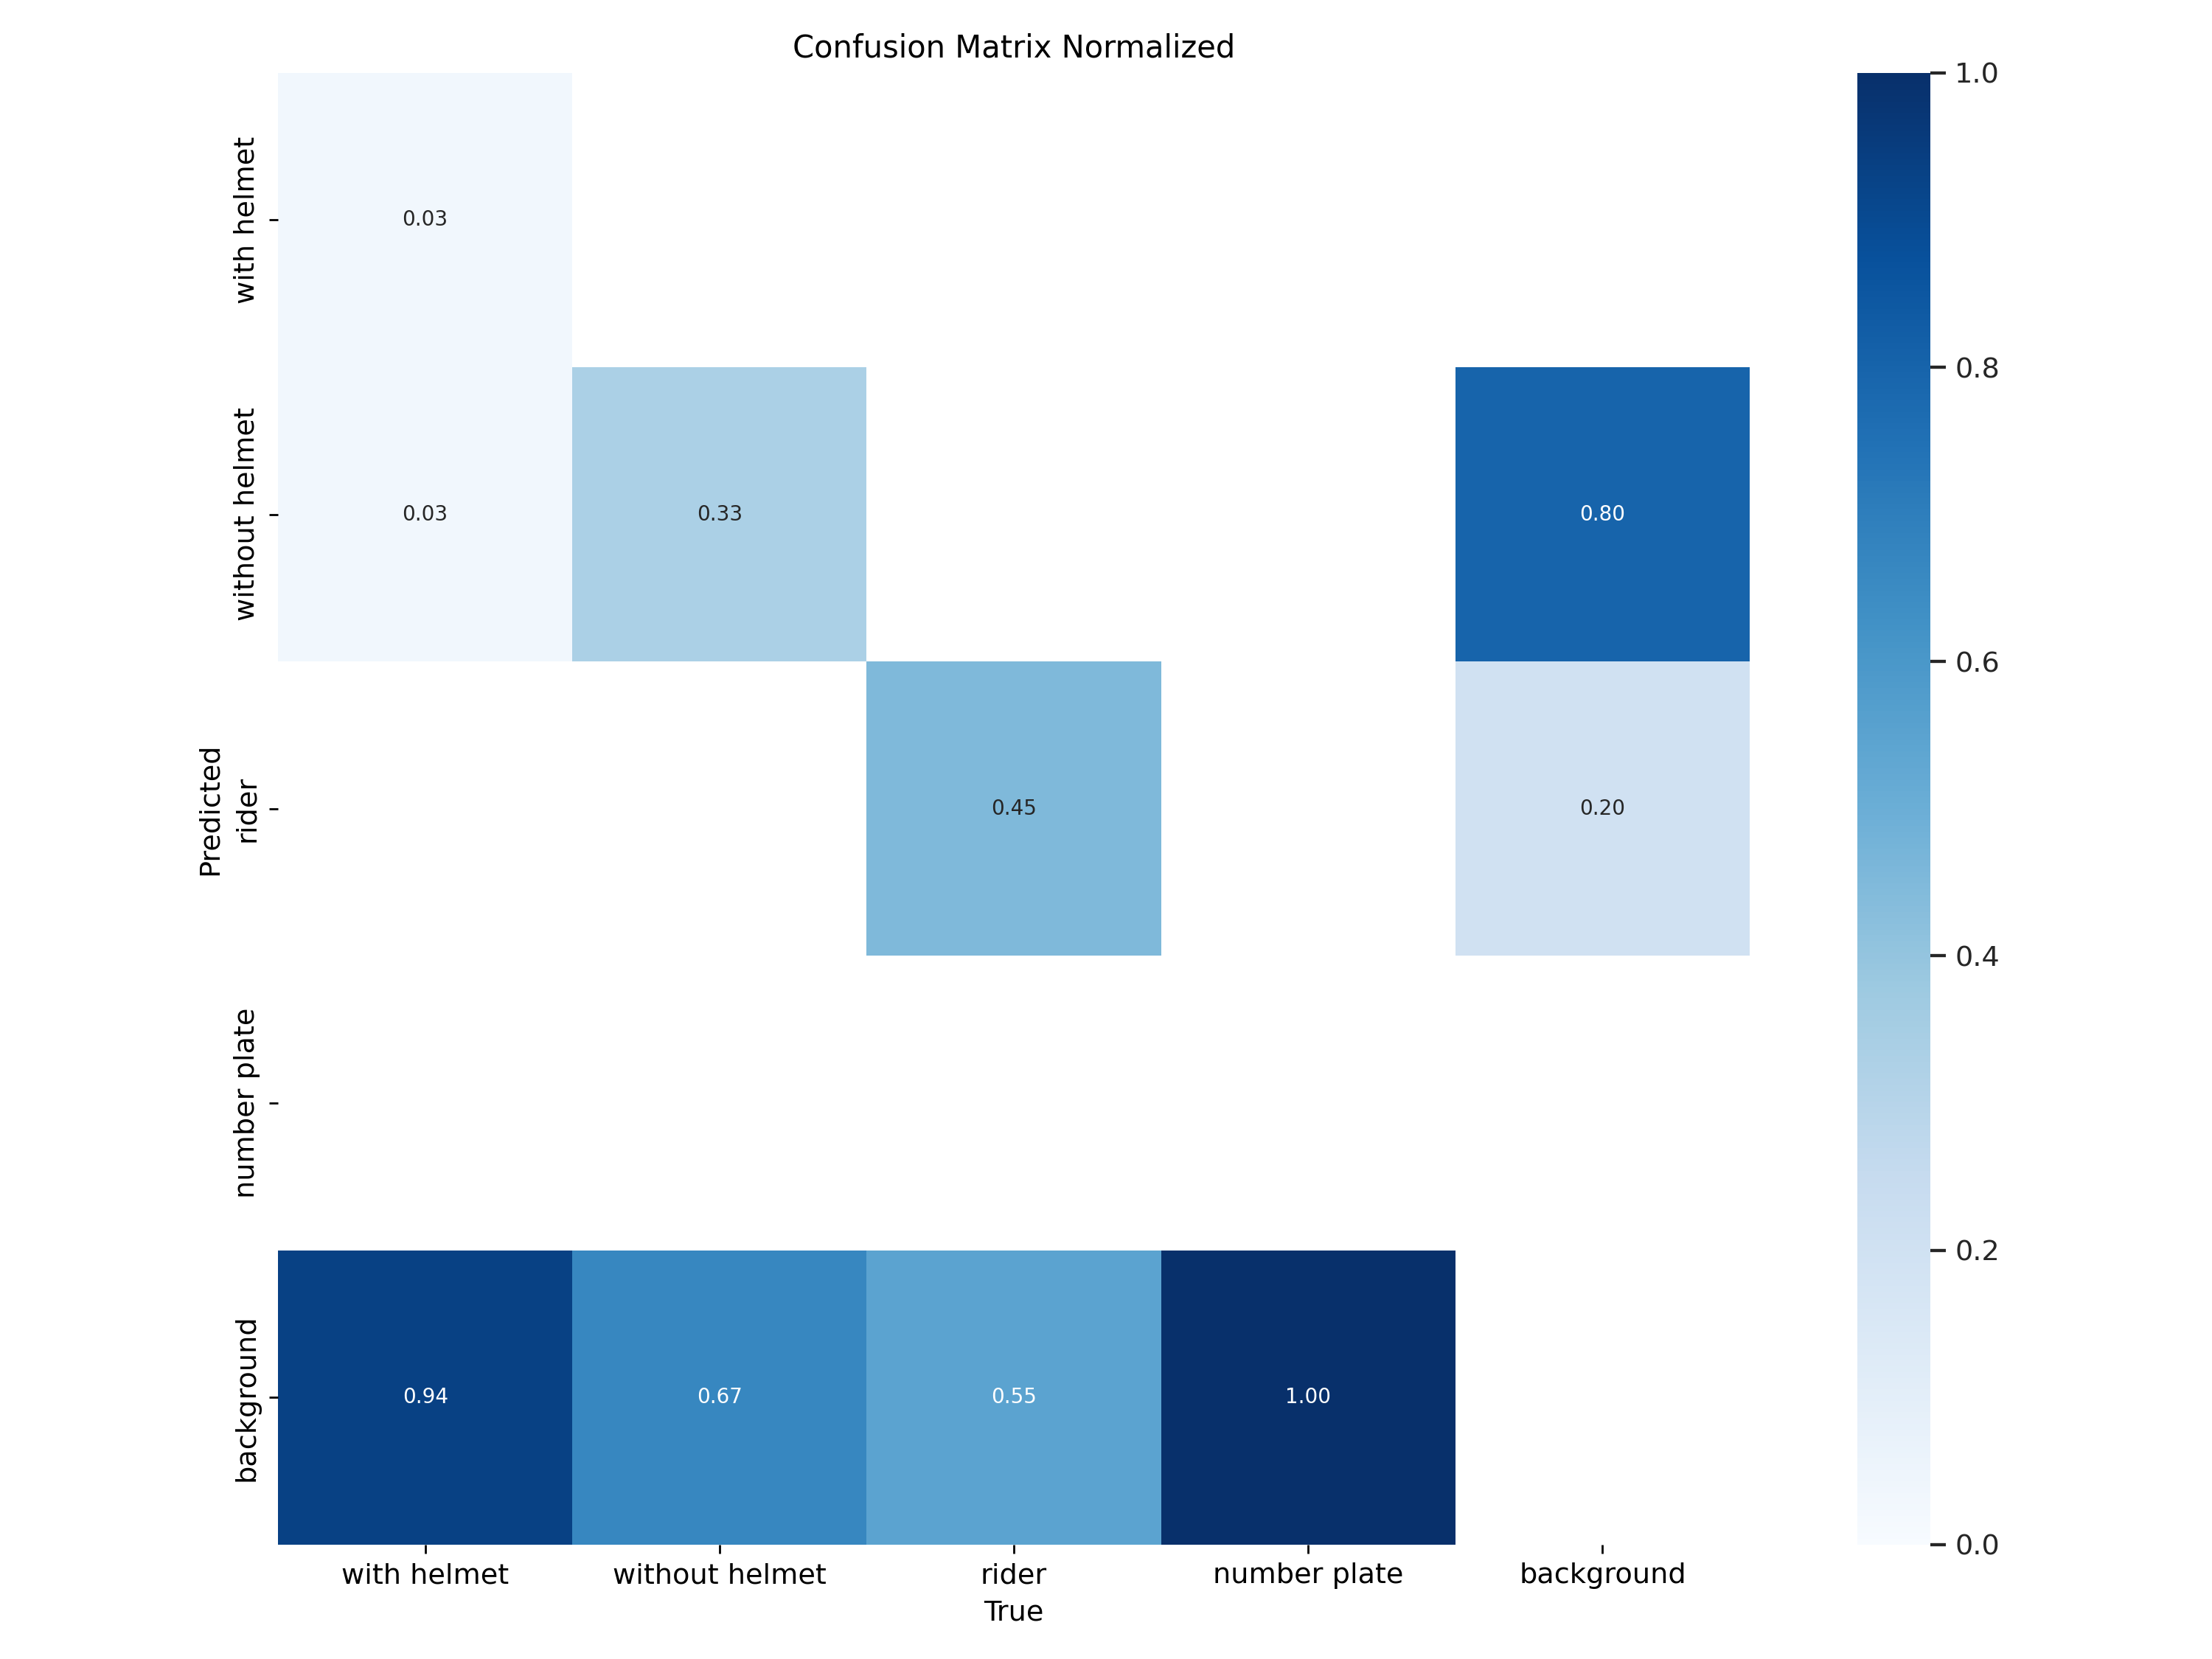

In [26]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/custom_training_run/confusion_matrix_normalized.png')

##Prediction

In [33]:
model = YOLO('/content/runs/detect/custom_training_run/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://awsimages.detik.net.id/community/media/visual/2023/03/14/marak-ugal-ugalan-bule-di-bali-bakal-dilarang-sewa-motor-1.jpeg', save=True)


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


  0%|          | 0.00/9.66k [00:00<?, ?B/s]

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


100%|██████████| 9.66k/9.66k [00:00<00:00, 26.1kB/s]


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/marak-ugal-ugalan-bule-di-bali-bakal-dilarang-sewa-motor-1.jpeg: 448x640 3 without helmets, 1404.3ms
Speed: 2.4ms preprocess, 1404.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2


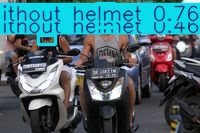

In [34]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict2/marak-ugal-ugalan-bule-di-bali-bakal-dilarang-sewa-motor-1.jpg')